# 🧠 Clustering Analysis Notebook

This notebook provides a **comprehensive evaluation** of the Reddit Topic Modeling pipeline using both **KMeans** and **HDBSCAN**.

## 📦 Load Clustered Results
We'll load all previously generated cluster files.

In [7]:
import os
os.chdir("..")  


In [10]:
import pandas as pd

df_k4 = pd.read_csv("data/reddit_kmeans_k4_clusters.csv", encoding="utf-8-sig")
df_k5 = pd.read_csv("data/reddit_kmeans_k5_clusters.csv", encoding="utf-8-sig")
df_hdb = pd.read_csv("data/reddit_hdbscan_clustered.csv", encoding="utf-8-sig")

print("✅ Data loaded successfully")

✅ Data loaded successfully


## 📊 Cluster Size Distribution
We’ll examine how many posts fall into each cluster.

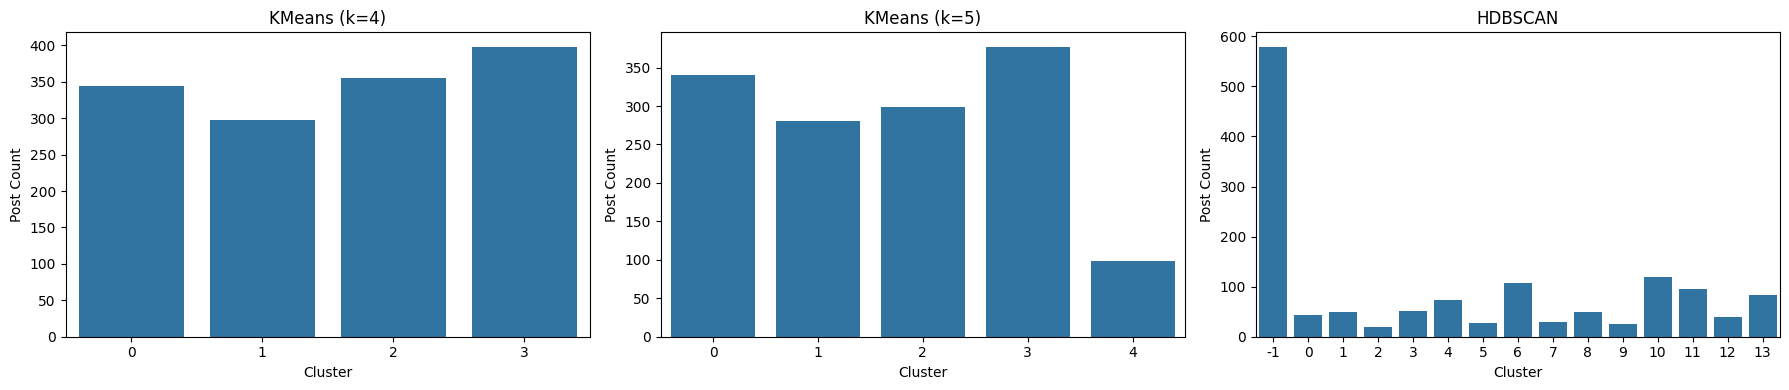

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Define datasets and the cluster column names
datasets = [
    (df_k4, "kmeans_k4", "KMeans (k=4)"),
    (df_k5, "kmeans_k5", "KMeans (k=5)"),
    (df_hdb, "cluster", "HDBSCAN")
]

# Plot cluster distribution for each
for ax, (df, col, title) in zip(axs, datasets):
    counts = df[col].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Post Count")

plt.tight_layout()
plt.show()

## 📈 Cluster Quality Evaluation

In [7]:
from sklearn.metrics import silhouette_score

# Keep only numeric columns for silhouette calculation
X_k4 = df_k4.select_dtypes(include='number').drop(columns=["kmeans_k4"], errors="ignore")
sil_k4 = silhouette_score(X_k4, df_k4["kmeans_k4"])
print(f"KMeans (k=4) Silhouette Score: {sil_k4:.3f}")

X_k5 = df_k5.select_dtypes(include='number').drop(columns=["kmeans_k5"], errors="ignore")
sil_k5 = silhouette_score(X_k5, df_k5["kmeans_k5"])
print(f"KMeans (k=5) Silhouette Score: {sil_k5:.3f}")

# HDBSCAN Noise Ratio
noise_ratio = (df_hdb["cluster"] == -1).mean()
print(f"HDBSCAN Noise Ratio: {noise_ratio:.2%}")


KMeans (k=4) Silhouette Score: -0.174
KMeans (k=5) Silhouette Score: -0.235
HDBSCAN Noise Ratio: 41.51%


## 🔑 Cluster Keywords Summary
Display the top keywords extracted with KeyBERT.

In [9]:
keywords_df = pd.read_csv("data/hdbscan_cluster_keywords.csv")
keywords_df.head(10)

,cluster,post_count,top_keywords
0,0,43,"nlp emotion, emotion classification, text emot..."
1,1,50,"compete nvidia, nvidia blackwell, gpu cloud, n..."
2,2,20,"ai laughing, ai artists, ai artist, art ai, ai..."
3,3,51,"tmlr papers, iclr papers, tmlr paper, best pap..."
4,4,74,"decoder llms, llm interpretability, learning l..."
5,5,27,"relu networks, learning relu, deep relu, relu ..."
6,6,107,"generative models, generative modeling, improv..."
7,7,30,"slm projects, creating slms, slms developer, s..."
8,8,50,"llm pipelines, models pipelines, mlops pipelin..."
9,9,26,"search spy, spy searcher, spy search, searcher..."


## ☁️ Optional: WordCloud per Cluster

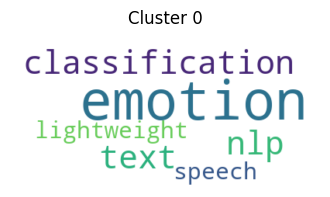

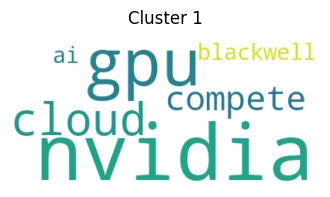

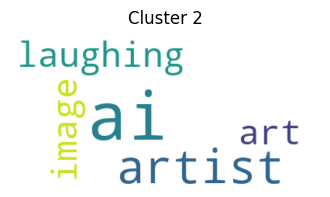

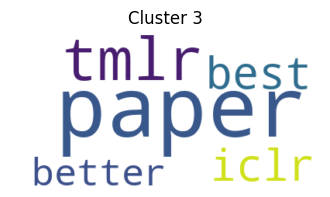

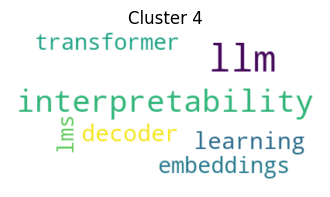

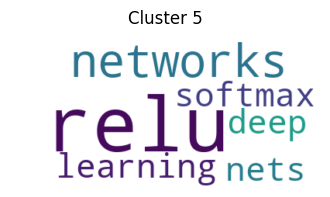

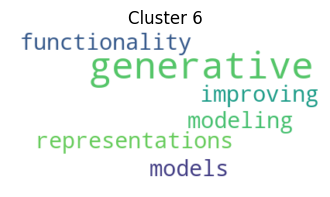

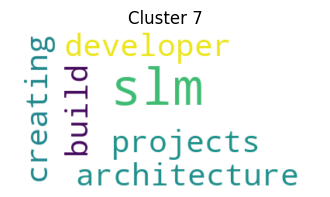

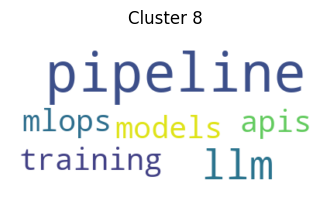

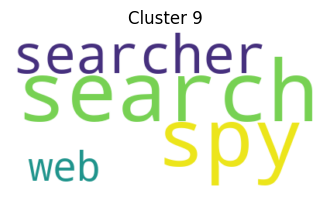

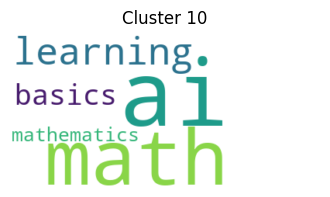

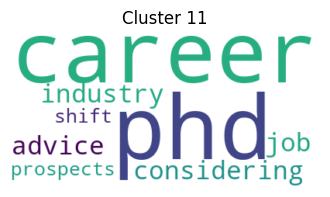

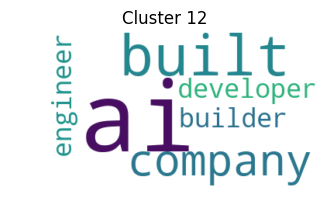

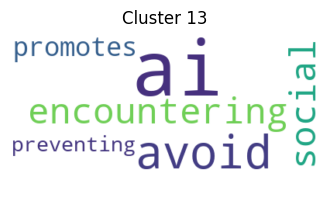

In [10]:
from wordcloud import WordCloud

for _, row in keywords_df.iterrows():
    wc = WordCloud(background_color='white').generate(row['top_keywords'])
    plt.figure(figsize=(4, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {row['cluster']}")
    plt.show()

## 🖼️ Visual Explorations

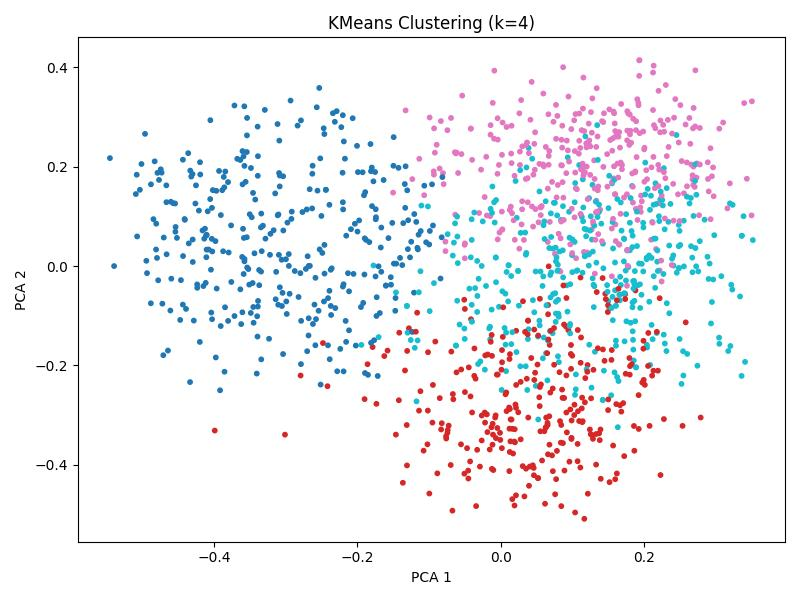

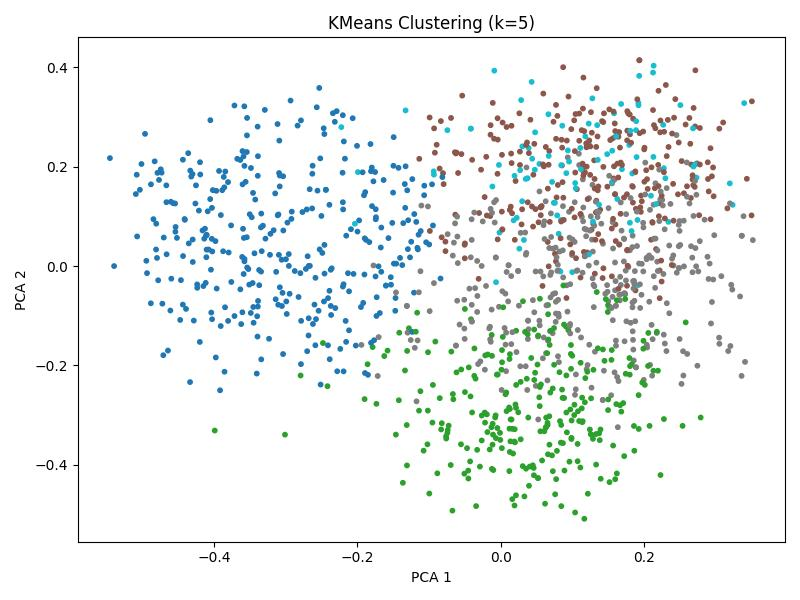

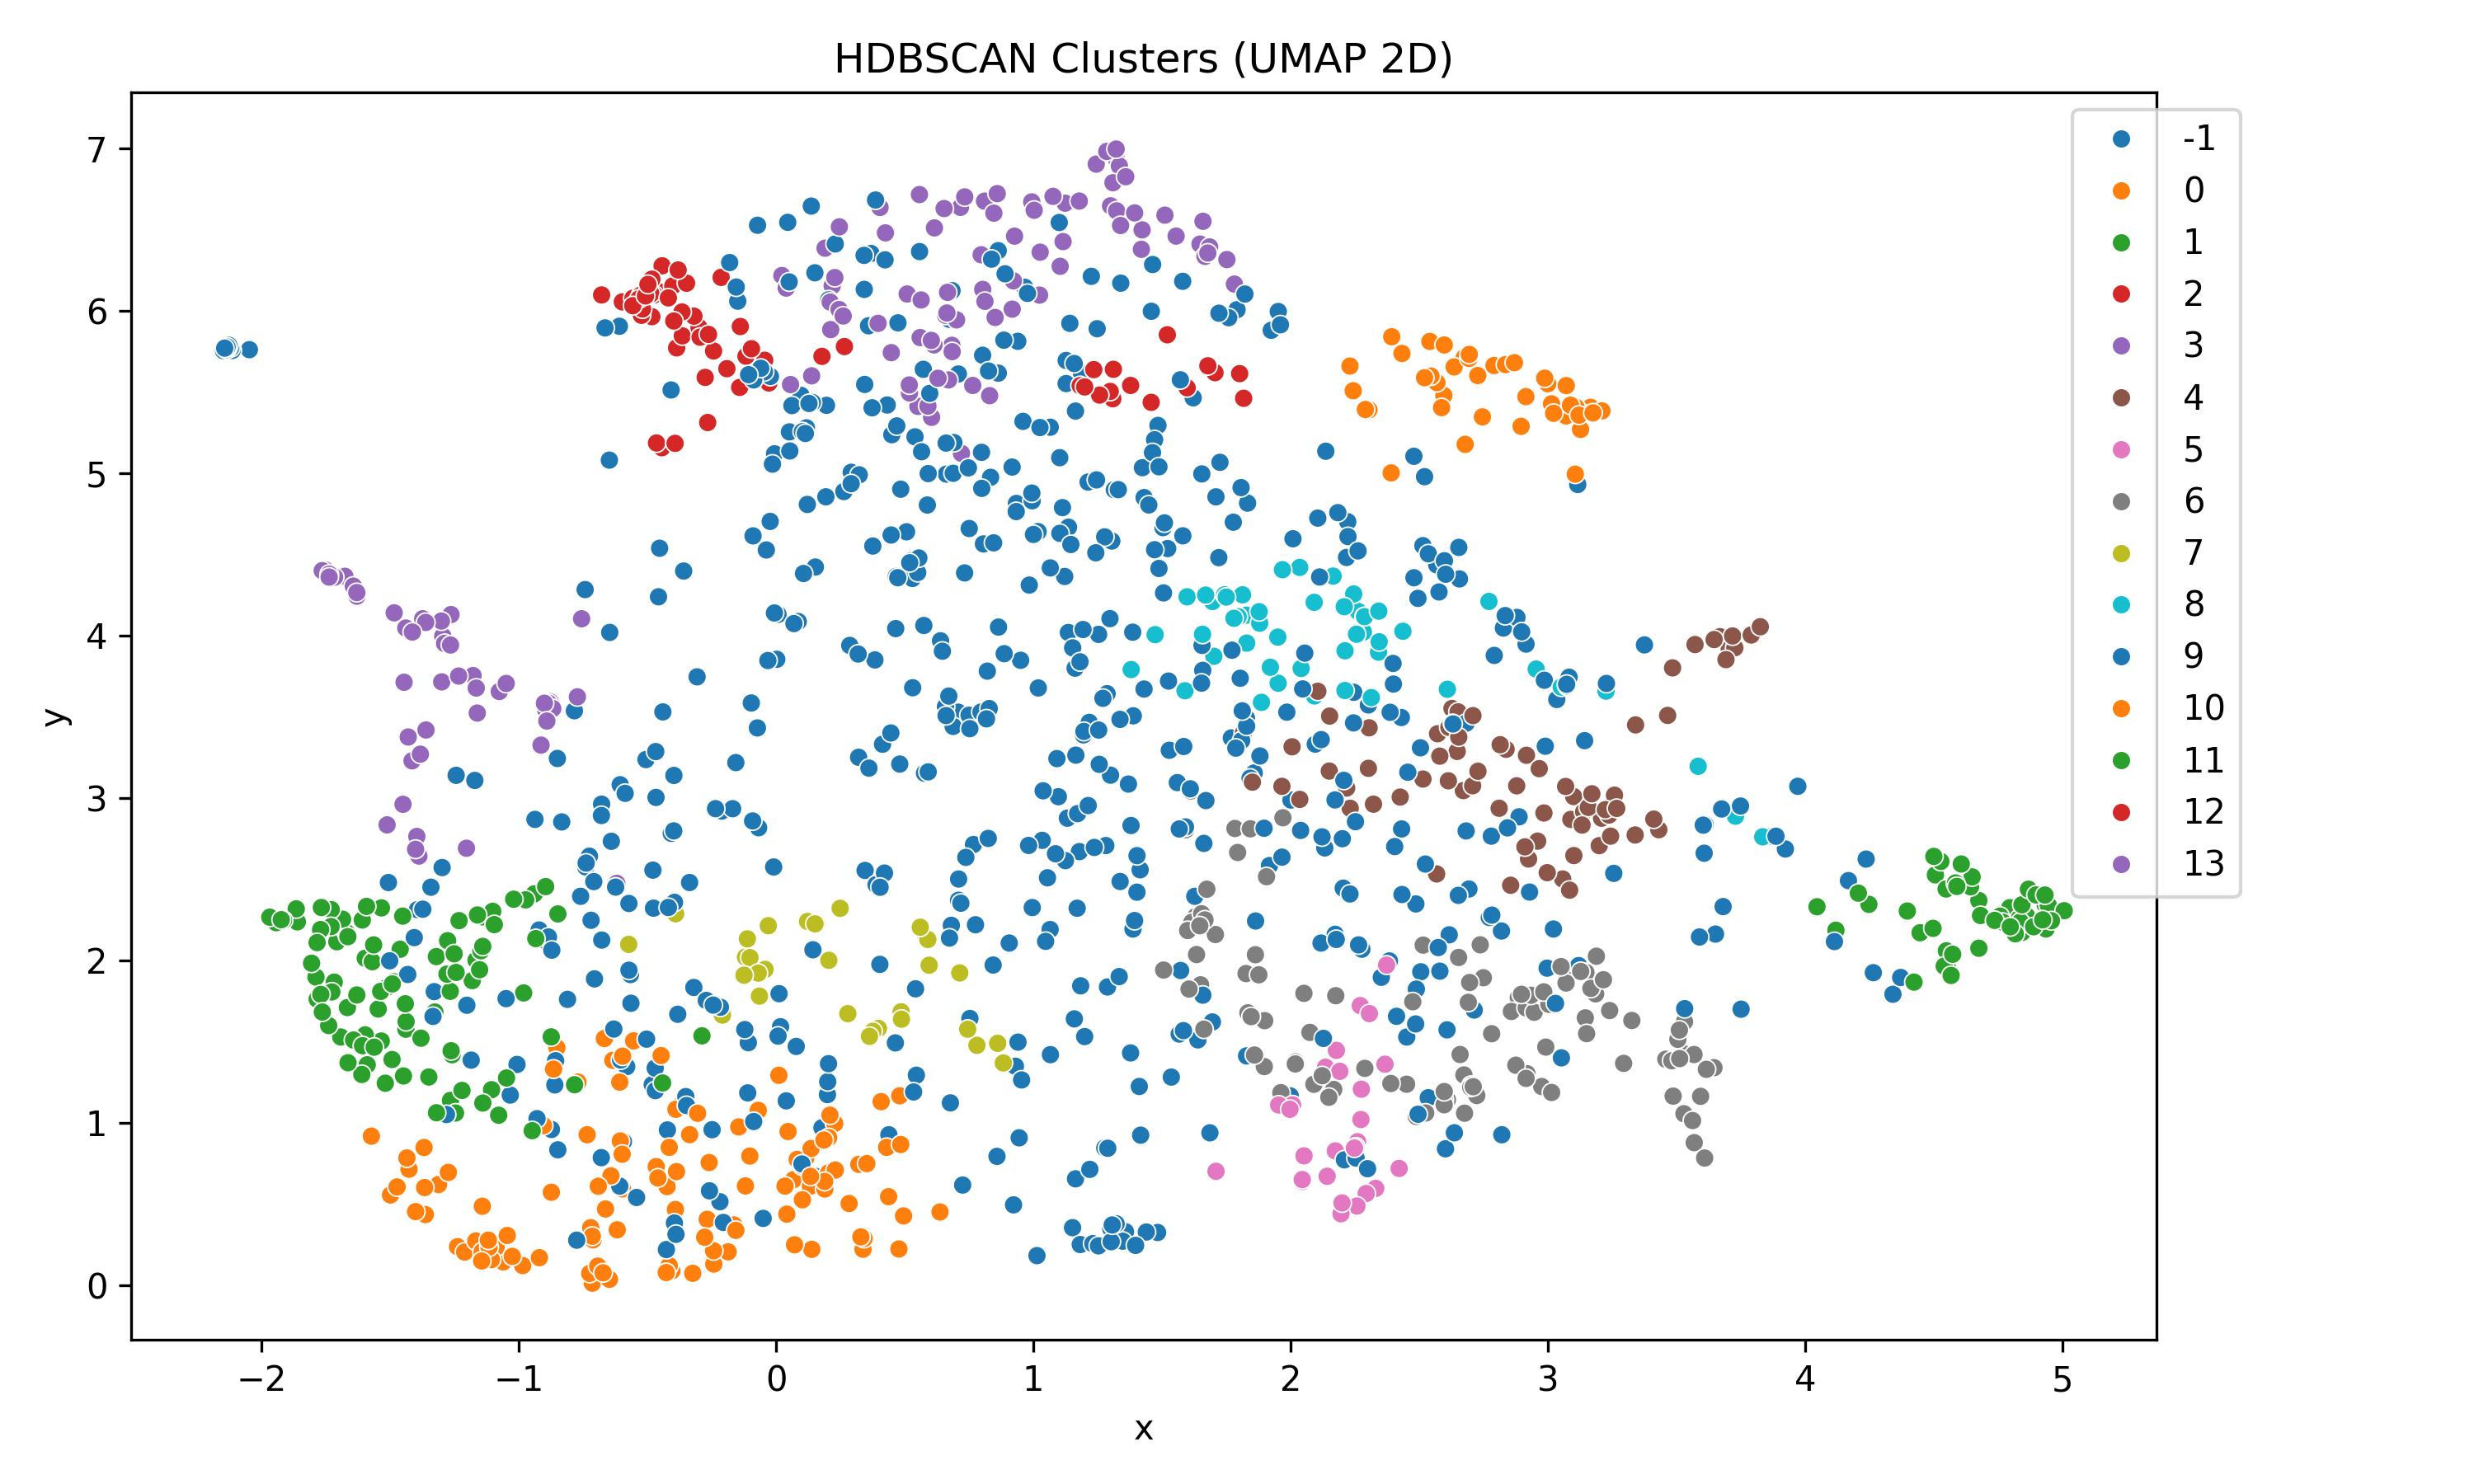

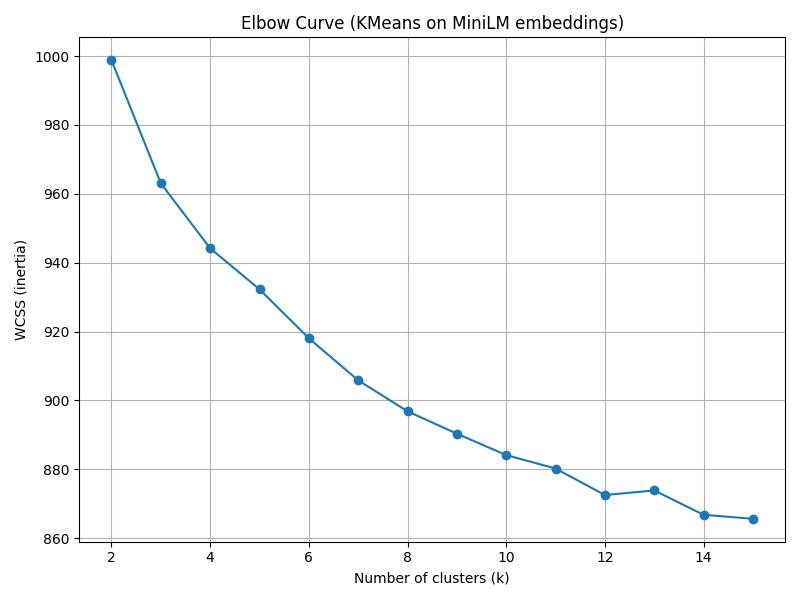

In [11]:
from IPython.display import Image, display

display(Image(filename="data/kmeans_k4.jpg"))
display(Image(filename="data/kmeans_k5.jpg"))
display(Image(filename="data/hdbscan_umap_plot.jpg"))
display(Image(filename="data/elbow.jpg"))

## 🎯 Final Verdict: HDBSCAN Wins

After evaluating KMeans (k=4, k=5) and HDBSCAN, we selected **HDBSCAN** as the most suitable clustering algorithm for this Reddit topic modeling task.

It provided:
- Better handling of noise and outliers  
- More natural, density-based clusters  
- Coherent keywords and topic labels  

👉 This makes **HDBSCAN** ideal for real-world text data, where structure is unknown and noise is expected.


### 🔑 Generate concise keyword-based summaries for each cluster using KeyBERT

In [4]:
from keybert import KeyBERT
from tqdm import tqdm

kw_model = KeyBERT("all-MiniLM-L6-v2")

def generate_summaries(df, label_col, text_col="text", top_n=5):
    summaries = {}
    for cluster_id in tqdm(sorted(df[label_col].dropna().unique())):
        cluster_texts = df[df[label_col] == cluster_id][text_col].dropna().astype(str)
        combined_text = " ".join(cluster_texts.tolist())[:10000]  # Limit for speed
        keywords = kw_model.extract_keywords(
            combined_text,
            keyphrase_ngram_range=(1, 3),
            stop_words="english",
            top_n=top_n
        )
        summaries[cluster_id] = ", ".join([kw for kw, _ in keywords])
    df["cluster_summary"] = df[label_col].map(summaries)
    return df


In [11]:
df_k4 = generate_summaries(df_k4, "kmeans_k4")
df_k5 = generate_summaries(df_k5, "kmeans_k5")
df_hdb = generate_summaries(df_hdb, "cluster")

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:48<00:00, 11.26s/it]


In [12]:
df_k4.to_csv("data/reddit_kmeans_k4_with_summary.csv", index=False, encoding="utf-8-sig")
df_k5.to_csv("data/reddit_kmeans_k5_with_summary.csv", index=False, encoding="utf-8-sig")
df_hdb.to_csv("data/reddit_hdbscan_with_summary.csv", index=False, encoding="utf-8-sig")